In [1]:
!jupyter nbconvert --to python seqInit.ipynb

[NbConvertApp] Converting notebook seqInit.ipynb to python
[NbConvertApp] Writing 1404 bytes to seqInit.py


---
### FC模型

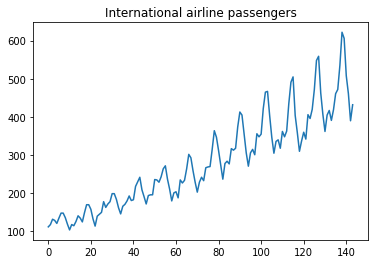

dataSet shape :	 (144, 1)
train data shape : (120, 1)
real data shape : (24, 1)


In [2]:
# 引入torch相关模块
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import init

# 引入初始化文件中的相关内容
from seqInit import toTs, cudAvl
from seqInit import input_size
from seqInit import train, real

# 引入画图工具
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 定义FC模型

class fcModel(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim) :
        super().__init__()
        ly, self.linear = 1, nn.Sequential()
        for hid in hidden_dim :
            layer = nn.Sequential(nn.Linear(in_dim, hid), nn.ReLU(True))
            self.linear.add_module('layer_{}'.format(ly), layer)
            ly, in_dim = ly + 1, hid
        self.linear.add_module('layer_{}'.format(ly), nn.Linear(in_dim, out_dim))
        
        # 使用kaiming_normal初始化模型参数
        self.weightInit(init.kaiming_normal)
    
    def forward(self, x) :
        x = self.linear(x)
        return x
    
    def weightInit(self, func) :
        for name, param in self.named_parameters() :
            if 'weight' in name : func(param)

# 输入为input_size，输出为1，隐藏层设定为3层，分别有[20, 10, 5]的维度
hidden = [20, 10, 5]
fc = cudAvl(fcModel(input_size, hidden, 1))

# 定义损失函数和优化函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fc.parameters(), lr = 1e-2)    

In [4]:
# 制造数据集函数
def create_dataset(dataset, look_back) :
    dataX, dataY = [], []
    for i in range(look_back, len(dataset)) :
        x = dataset[i - look_back: i]
        y = dataset[i]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)
# 制造训练集
trainX, trainY = create_dataset(train, input_size)
print(trainX.shape, trainY.shape)

# 制造测试集
testX, realY = create_dataset(real, input_size)
print(testX.shape, realY.shape)

(117, 3, 1) (117, 1)
(21, 3, 1) (21, 1)


In [5]:
# 处理输入
fcx = trainX.reshape(-1, 3)
fcx = torch.from_numpy(fcx)
fcy = trainY.reshape(-1, 1)
fcy = torch.from_numpy(fcy)
print(fcx.shape, fcy.shape)

torch.Size([117, 3]) torch.Size([117, 1])


Epoch[1/10], Loss: 0.03160
Epoch[2/10], Loss: 0.01490
Epoch[3/10], Loss: 0.00586
Epoch[4/10], Loss: 0.00436
Epoch[5/10], Loss: 0.00307
Epoch[6/10], Loss: 0.00291
Epoch[7/10], Loss: 0.00279
Epoch[8/10], Loss: 0.00269
Epoch[9/10], Loss: 0.00265
Epoch[10/10], Loss: 0.00261


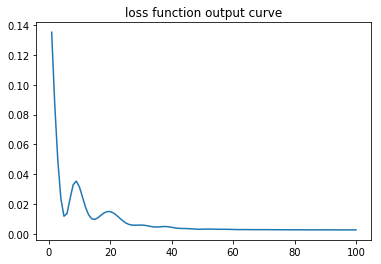

CPU times: user 125 ms, sys: 98.8 ms, total: 224 ms
Wall time: 116 ms


In [6]:
%%time
# 训练FC模型
frq, sec = 100, 10
loss_set = []
for e in range(1, frq + 1) :
    inputs = cudAvl(Variable(fcx))
    target = cudAvl(Variable(fcy))
    # forward
    outputs = fc(inputs)
    loss = criterion(outputs, target)
    # reset gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # print training infomation
    print_loss = loss.data[0]
    current = e // sec
    loss_set.append((e, print_loss))
    if e % sec == 0 :
        print_info = 'Epoch[{}/{}], Loss: {:.5f}'.format(current, frq // sec, print_loss)
        print(print_info)

# 作出损失函数变化图像
pltX = np.array([loss[0] for loss in loss_set])
pltY = np.array([loss[1] for loss in loss_set])
plt.title('loss function output curve')
plt.plot(pltX, pltY)
plt.show()

(21, 3) (21, 1)


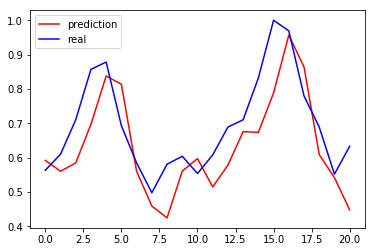

In [8]:
# 测试

px, ry = create_dataset(real, input_size)
px = px.reshape(-1, 3)
ry = ry.reshape(-1, 1)
print(px.shape, ry.shape)
px = torch.from_numpy(px)
px = cudAvl(Variable(px))
py = np.array(fc(px).data)

# 画出实际结果和预测的结果
plt.plot(py, 'r', label='prediction')
plt.plot(ry, 'b', label='real')
plt.legend(loc='best')